## Library installation

In [1]:
#Libraries to import
import pandas as pd
import yfinance as yfinance
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
import numpy as np
import time

## Data Initialisation (Cleaning)

In [2]:
#Scrapigng the data for stock prices

import yfinance as yf
import pandas as pd
tickers = ["^GSPC"]
start_date = "2020-01-01"
end_date = "2025-04-17"

data = yf.download(tickers, start=start_date, end=end_date)
data.to_csv('/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/Datasets/dataframe.csv')
df= pd.read_csv('/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/Datasets/dataframe.csv')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
#Cleaning the data 
df.drop(["Close", "High", "Volume", "Low"], axis=1, inplace=True)

In [4]:
df.head()

,Price,Open
0,Ticker,^GSPC
1,Date,NaN
2,2020-01-02,3244.669921875
3,2020-01-03,3226.360107421875
4,2020-01-06,3217.550048828125


In [5]:
#Cleaning rows and columns
df.columns = ["Date", "SPX"]  
df = df[df["Date"] != "NaN"]  

df = df.drop([0, 1])  
df = df.reset_index(drop=True)

df = df.round(2)

In [6]:
#Time-series set date variable
df["Date"] = pd.to_datetime(df["Date"])  
df.set_index("Date", inplace=True)  

In [7]:
import time
if isinstance(df.index, pd.DatetimeIndex):
    print("Time Series has been set")
else:
    print("Time Series has not been set yet")
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    time.sleep(3)
    print("It has been done now!")    

Time Series has been set


In [8]:
df.head()

,SPX
Date,
2020-01-02,3244.669921875
2020-01-03,3226.360107421875
2020-01-06,3217.550048828125
2020-01-07,3241.860107421875
2020-01-08,3238.590087890625


In [9]:
df.describe()

,SPX
count,1330
unique,1326
top,3963.340087890625
freq,2


In [10]:
#Segregating dataset into the training and testing model. We have decided to go for a (70:30 split)
#df = training set
#df_test = testing set
size = int(len(df)*0.7)
df, df_test = df.iloc[:size], df.iloc[size:] #df = training set and has 70% of the data, 
                                             #df_test = testing set and has 30% of the data

In [11]:
df.describe()

,SPX
count,930
unique,926
top,3963.340087890625
freq,2


In [12]:
df_test.describe()

,SPX
count,400
unique,400
top,4462.64990234375
freq,1


## Visualising data and preparing for training phase

In [13]:
df['SPX'] = pd.to_numeric(df['SPX'], errors='coerce')
df["SPX"].describe()

count     930.000000
mean     3926.816941
std       523.046527
min      2290.709961
25%      3633.654968
50%      4001.204956
75%      4356.089844
max      4804.509766
Name: SPX, dtype: float64

Text(0.5, 1.0, 'SPX Prices')

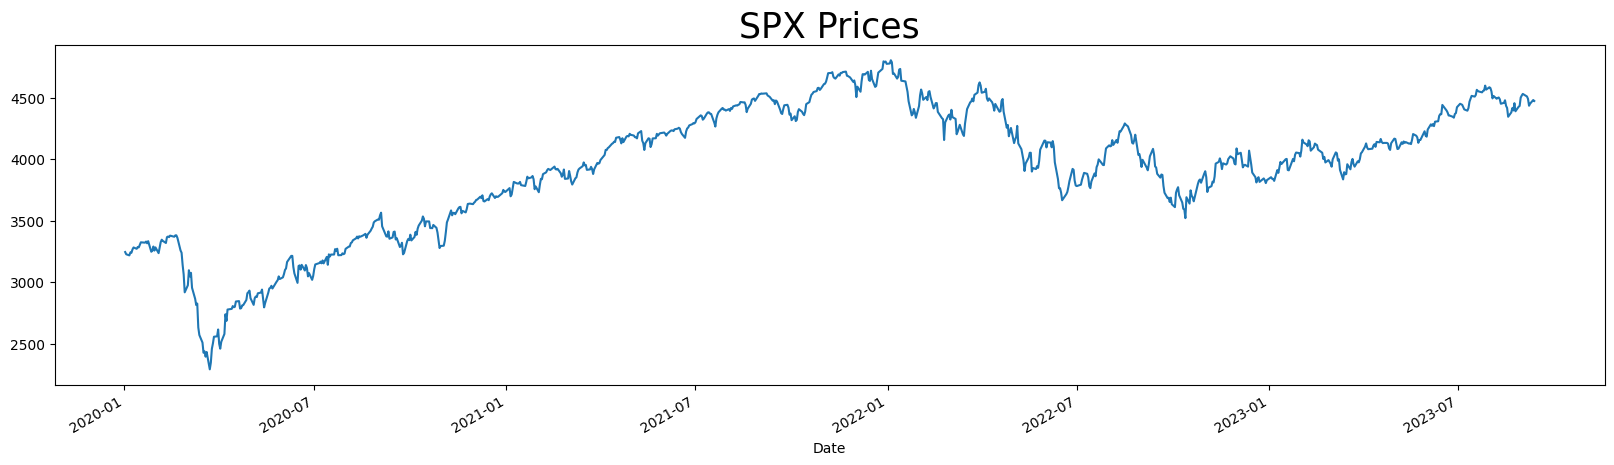

In [14]:
#Plotting the data
import matplotlib.pyplot as plt
df["SPX"].plot(figsize=(20,5))
plt.title("SPX Prices", size = 25)

### Testing for Stationarity 

In [15]:
#Dickey-Fuller Test
import statsmodels.tsa.stattools as sts
adf_result = sts.adfuller(df.SPX)

adf_pvalue = adf_result[1]

print(adf_result)
print(f'p-value from ADF test = {adf_pvalue}')

(-1.4986175702522344, 0.5341950959548422, 1, 928, {'1%': -3.4374162506455126, '5%': -2.8646595140022946, '10%': -2.568431020409111}, 9478.72621660242)
p-value from ADF test = 0.5341950959548422


In [16]:
print(f'We find the p-value = {adf_result[1]}')
#Since the p-value is greater than 0.05, we cannot reject H0, and therefore SPX is not stationary in levels form

We find the p-value = 0.5341950959548422


In [17]:
df['d.SPX'] = df.SPX.diff(1)
df= df.dropna()
df.head()

,SPX,d.SPX
Date,,
2020-01-03,3226.360107,-18.309814
2020-01-06,3217.550049,-8.810059
2020-01-07,3241.860107,24.310059
2020-01-08,3238.590088,-3.270020
2020-01-09,3266.030029,27.439941


Text(0.5, 1.0, 'S&P 500 Prices (First Difference)')

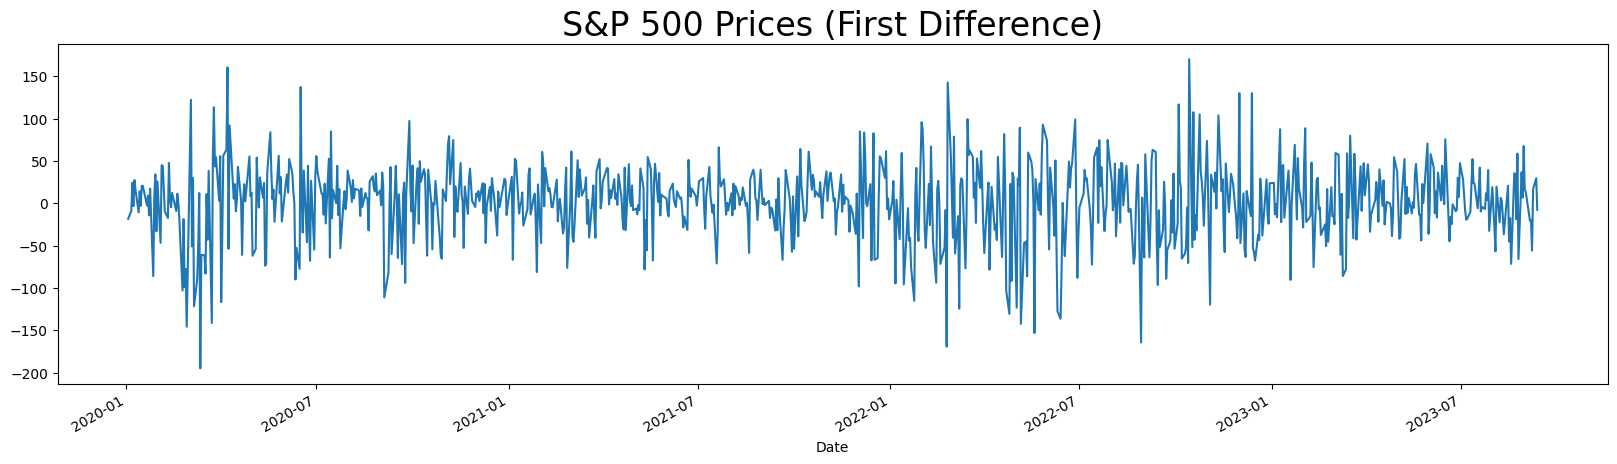

In [20]:
df['d.SPX'].plot(figsize=(20,5))
plt.title("S&P 500 Prices (First Difference)", size=24) 

Here, we see that when the S&P 500 has been differenced once, our plot already look stationary. To confirm, we should run the ADF test again.

In [21]:
adf_result2 = sts.adfuller(df['d.SPX'])
print(f'We find the p-value = {adf_result2[1]}')
#Since the p-value is less than 0.05, we can reject H0, and therefore SPX is stationary in first-diff (I=1) form

We find the p-value = 0.0


We see that the p-value < 0.05, so (via. the ADF test) we find that prices are now stationary (in first difference form).

### Identifying Optimal AR and MA lags

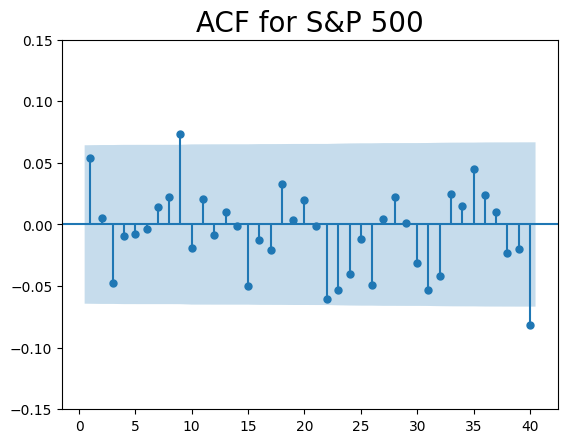

(-0.15, 0.15)

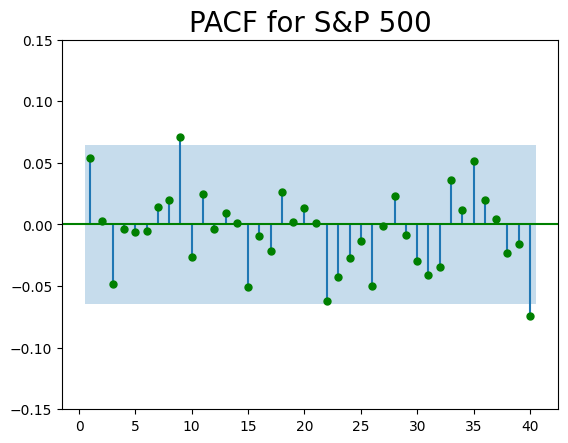

In [19]:
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt

# Plot the ACF for first difference S&P 500
price_acf = sgt.plot_acf(df['d.SPX'], zero=False, lags=40)
plt.title("ACF for S&P 500", size=20)
plt.gca().set_ylim(-0.15, 0.15)
plt.show()

#Plot PACF for first difference S&P 500
price_pacf = sgt.plot_pacf(df['d.SPX'], zero = False, lags = 40, color = "green")
plt.title("PACF for S&P 500", size = 20)
plt.gca().set_ylim(-0.15, 0.15)

#From visually looking, we find that an AR(9) model seems to be the most optimal lag

### Fitting the Model

In [23]:
import pmdarima as pm
# Define the maximum number of lags to consider
max_lags = 10

# Function to find the best ARIMA order using different information criteria
def find_best_arima_order(series, max_lags, criterion):
    model = pm.auto_arima(
        series,
        start_p=0, start_q=0,
        max_p=15, max_q=15,
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        information_criterion=criterion
    )
    return model.order

# Find the best ARIMA order for spx using AIC, BIC, and HQIC
spx_orders = {
    'AIC': find_best_arima_order(df['SPX'], max_lags, 'aic'),
    'BIC': find_best_arima_order(df['SPX'], max_lags, 'bic'),
    'HQIC': find_best_arima_order(df['SPX'], max_lags, 'hqic')
}

# Print the selected ARIMA orders for yt
for criterion, order in spx_orders.items():
    print(f'Selected ARIMA order for spx using {criterion}: {order}')

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warning

Selected ARIMA order for spx using AIC: (0, 1, 0)
Selected ARIMA order for spx using BIC: (0, 1, 0)
Selected ARIMA order for spx using HQIC: (0, 1, 0)


We see that there aren't any discrepancies between the information criterion, so for now, we can confidently go ahead with an ARIMA(0,1,0) model.

In [28]:
model_spx_010 = ARIMA(df["SPX"], order=(0,1,0))
results_model_spx_010 = model_spx_010.fit()
print(results_model_spx_010.summary())

                               SARIMAX Results                                
Dep. Variable:                    SPX   No. Observations:                  929
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4837.796
Date:                Thu, 17 Apr 2025   AIC                           9677.592
Time:                        15:02:42   BIC                           9682.425
Sample:                             0   HQIC                          9679.435
                                - 929                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1975.1661     69.186     28.549      0.000    1839.565    2110.767
Ljung-Box (L1) (Q):                   2.69   Jarque-Bera (JB):               119.86
Prob(Q):                              0.10   Pr

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


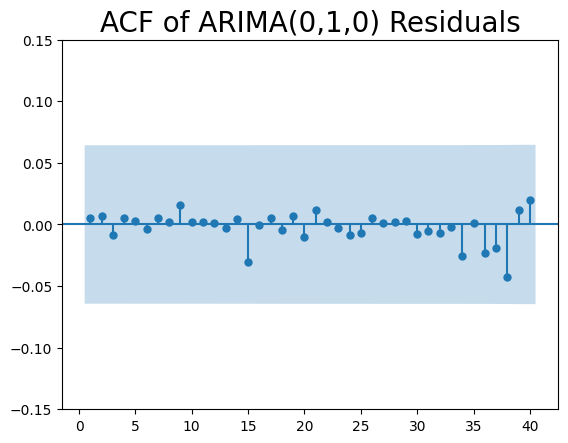

In [30]:
model_spx_010_res = results_model_spx_010.resid 

sgt.plot_acf(model_spx_010_res, zero=False, lags=40)
plt.title("ACF of ARIMA(0,1,0) Residuals", size=20)
plt.gca().set_ylim(-0.15, 0.15)
plt.show()

In [32]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
ljung_box_results = acorr_ljungbox(model_spx_010_res, lags=[10], return_df=True)

# Print the results
print(ljung_box_results)

     lb_stat  lb_pvalue
10  0.467093   0.999995


Using the Ljung-Box test, we see that there is no statistical evidence to reject H0, suggesting that there is no autocorrelation within our residuals - thus exhibiting white noise. This is what we want as we want to train our model to adapt to any type of data and not overfit our training dataset.

### Forecasting

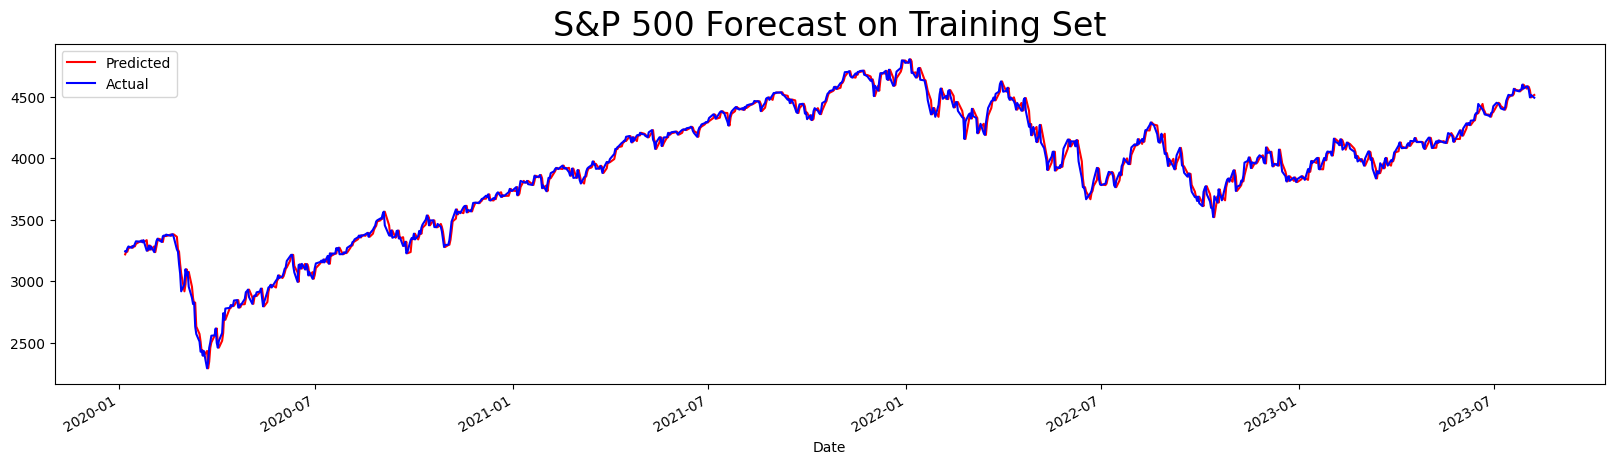

In [33]:
start_date = "2020-01-07"
end_date = "2023-08-07"

df_forecast = results_model_spx_010.predict(start=start_date, end=end_date)

df_forecast[start_date:end_date].plot(figsize=(20, 5), color="red", label='Predicted')
df['SPX'][start_date:end_date].plot(color="blue", label='Actual')
plt.title("S&P 500 Forecast on Training Set", size=24)
plt.legend()
plt.show()

In [34]:
# Ensure the predicted and actual values align
predicted = df_forecast[start_date:end_date]
actual = df['SPX'][start_date:end_date]

# Calculate Mean Absolute Percentage Error (MAPE)
mape = (abs(predicted - actual) / actual).mean() * 100

# Calculate accuracy as (100% - MAPE)
accuracy = 100 - mape

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Prediction Accuracy: {accuracy:.2f}%")

Mean Absolute Percentage Error (MAPE): 0.89%
Prediction Accuracy: 99.11%
